In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "SL_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path

# Load Files

In [16]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_SL_SC_path, dtype=dtype).sample(frac=0.05, random_state=1)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [17]:
len(windmill)

48

In [18]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [19]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [20]:
df = features.parallelize_extract(df)

parallelize_extract time:  2896.6055250167847


In [21]:
df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [22]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [23]:
cols = [x for x in df.columns if x not in cols_filter]
df[cols] = tools.normalize_maxmin(df[cols])
df['VAERDI'] = df['VAERDI'] / df['max_VAERDI'] 

In [24]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [25]:
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)

In [26]:
df_train.to_parquet(constant.SL_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.SL_SC_EVL_path, index=False)

# Neural Network Train

In [2]:
df_train = pd.read_parquet(constant.SL_SC_TRAIN_path)

In [3]:
len(df_train)

445587

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

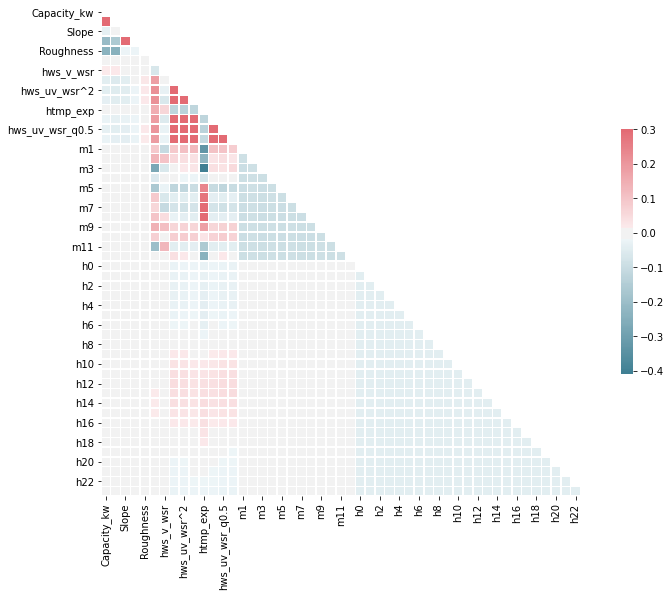

In [14]:
corrMatrix = df_train[semigeo_cols].corr()
mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [5]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=40
hidden_size = 1000
output_size = 1

## Original Features


In [6]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [7]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.033895425498485565 test loss: 0.026359640061855316
Epoch 10 train loss: 0.023234842345118523 test loss: 0.02143002673983574
Epoch 20 train loss: 0.022214410826563835 test loss: 0.021446453407406807
Epoch 30 train loss: 0.02144343964755535 test loss: 0.021991241723299026
Epoch 39 train loss: 0.020843690261244774 test loss: 0.022273777052760124
Epoch 0 train loss: 0.02228165604174137 test loss: 0.008659192360937595
Epoch 10 train loss: 0.02227628231048584 test loss: 0.010038421489298344
Epoch 20 train loss: 0.02117667719721794 test loss: 0.008472702465951443
Epoch 30 train loss: 0.02055024541914463 test loss: 0.00827447883784771
Epoch 39 train loss: 0.01975785382091999 test loss: 0.00830571074038744
Epoch 0 train loss: 0.019407613202929497 test loss: 0.010847900994122028
Epoch 10 train loss: 0.019767887890338898 test loss: 0.012179785408079624
Epoch 20 train loss: 0.01908276416361332 test loss: 0.01166850607842207
Epoch 30 train loss: 0.018369298428297043 test loss:

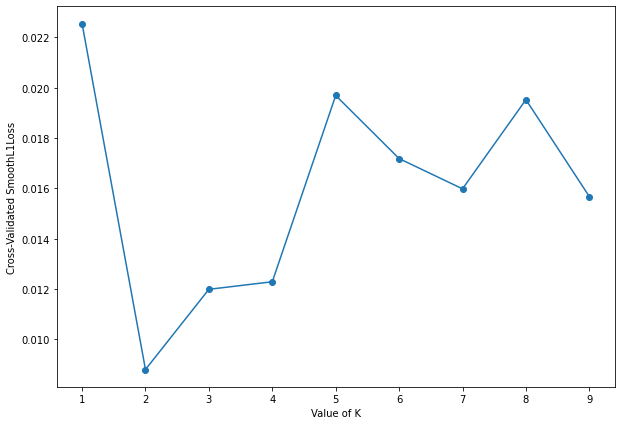

In [8]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"original_k_fold.png")

### Train model

In [7]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [8]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"original_model.pth")

Epoch 0 train loss: 0.03803008422255516
Epoch 10 train loss: 0.02264680527150631
Epoch 20 train loss: 0.02191881090402603
Epoch 30 train loss: 0.021263904869556427


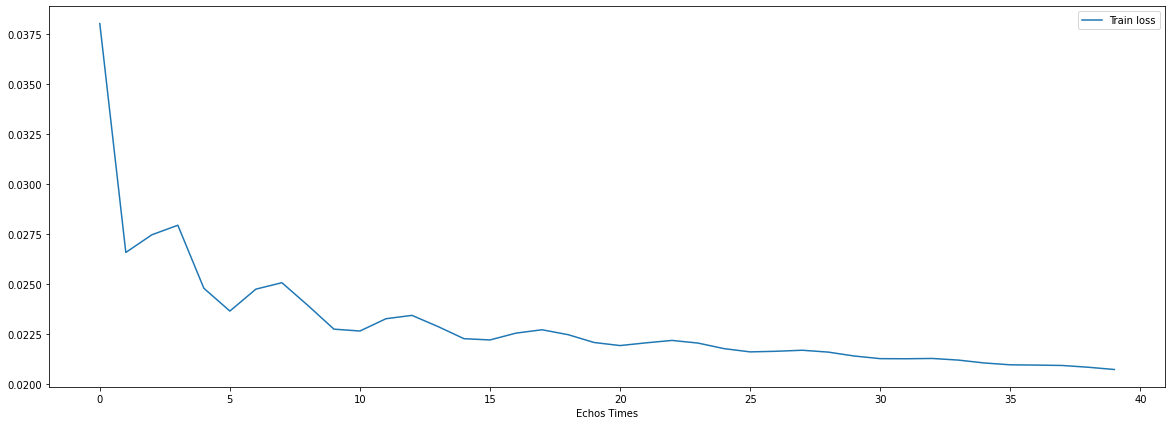

In [20]:
myplot.model_loss({"Train loss":train_hist_original}, path=plot_path+"original_loss.png")

## Windshear Features

In [9]:
model_wsr = MLP_Regression(
  input_size=47,
  hidden_size=hidden_size
)

In [10]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.034108664840459824 test loss: 0.027494575828313828
Epoch 10 train loss: 0.011640292592346668 test loss: 0.011485276743769646
Epoch 20 train loss: 0.009454545564949512 test loss: 0.010238423943519592
Epoch 30 train loss: 0.008433698676526546 test loss: 0.008767480030655861
Epoch 39 train loss: 0.008345159702003002 test loss: 0.008218560367822647
Epoch 0 train loss: 0.008726821281015873 test loss: 0.004751988686621189
Epoch 10 train loss: 0.010305479168891907 test loss: 0.005825702100992203
Epoch 20 train loss: 0.008729134686291218 test loss: 0.00482046976685524
Epoch 30 train loss: 0.008479938842356205 test loss: 0.004588107578456402
Epoch 39 train loss: 0.00850646197795868 test loss: 0.004570676479488611
Epoch 0 train loss: 0.008297293446958065 test loss: 0.005917523987591267
Epoch 10 train loss: 0.009903187863528728 test loss: 0.006807870231568813
Epoch 20 train loss: 0.008277609944343567 test loss: 0.005990924313664436
Epoch 30 train loss: 0.008398286998271942 t

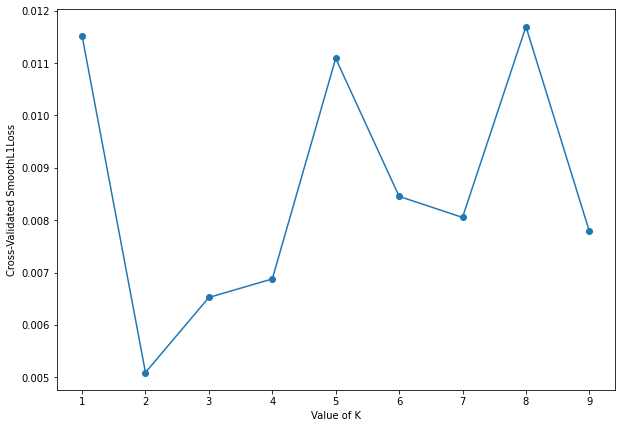

In [11]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"wsr_k_fold.png")

### Train model

In [22]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [23]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"wsr_model.pth")

Epoch 0 train loss: 0.03786855936050415
Epoch 10 train loss: 0.012328840792179108
Epoch 20 train loss: 0.009399071335792542
Epoch 30 train loss: 0.008479983545839787


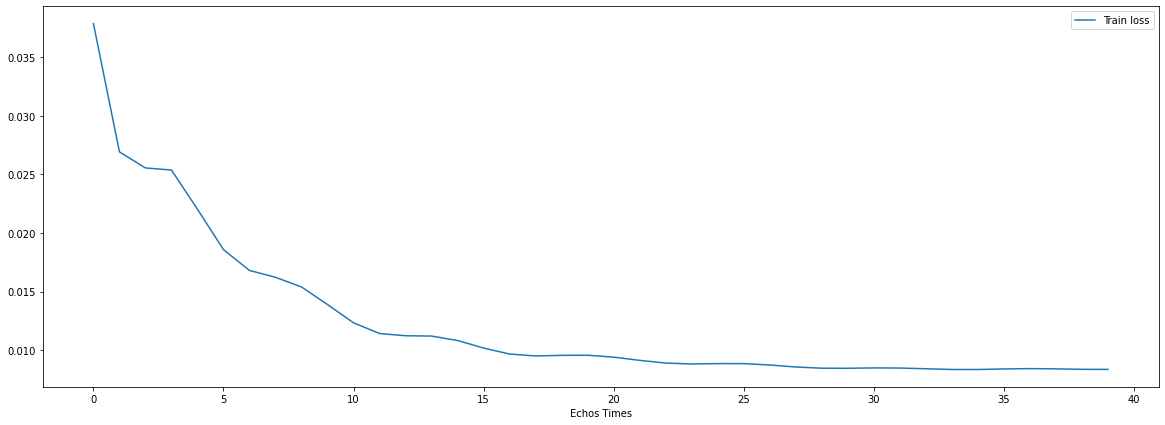

In [24]:
myplot.model_loss({"Train loss":train_hist_wsr}, path=plot_path+"wsr_loss.png")

## Geo Features

In [12]:
model_geo = MLP_Regression(
  input_size=49,
  hidden_size=hidden_size
)

In [13]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.030829383060336113 test loss: 0.028980113565921783
Epoch 10 train loss: 0.01197338942438364 test loss: 0.011927870102226734
Epoch 20 train loss: 0.009630775079131126 test loss: 0.010011794045567513
Epoch 30 train loss: 0.008930295705795288 test loss: 0.009058266878128052
Epoch 39 train loss: 0.008720100857317448 test loss: 0.008683806285262108
Epoch 0 train loss: 0.009159593842923641 test loss: 0.0048195598646998405
Epoch 10 train loss: 0.0107487253844738 test loss: 0.006513149011880159
Epoch 20 train loss: 0.009021349251270294 test loss: 0.004918189253658056
Epoch 30 train loss: 0.00894101057201624 test loss: 0.004729273729026318
Epoch 39 train loss: 0.008927246555685997 test loss: 0.004685970023274422
Epoch 0 train loss: 0.008709141984581947 test loss: 0.006336686667054892
Epoch 10 train loss: 0.010208547115325928 test loss: 0.0070678903721272945
Epoch 20 train loss: 0.008670019917190075 test loss: 0.006301600020378828
Epoch 30 train loss: 0.00864673312753439 te

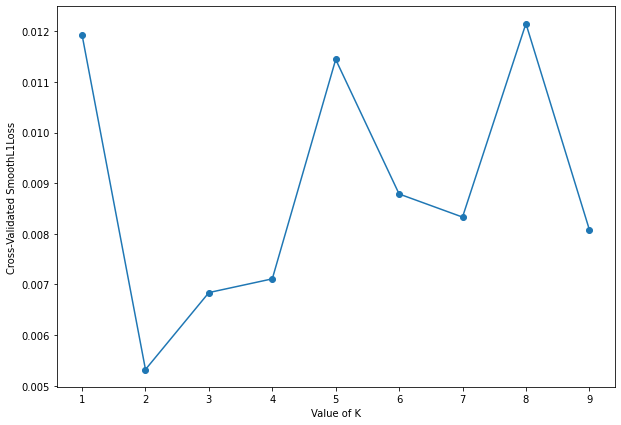

In [14]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"geo_k_fold.png")

### Train model

In [26]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [27]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"geo_model.pth")

Epoch 0 train loss: 0.03591400384902954
Epoch 10 train loss: 0.01228225976228714
Epoch 20 train loss: 0.009763290174305439
Epoch 30 train loss: 0.008891881443560123


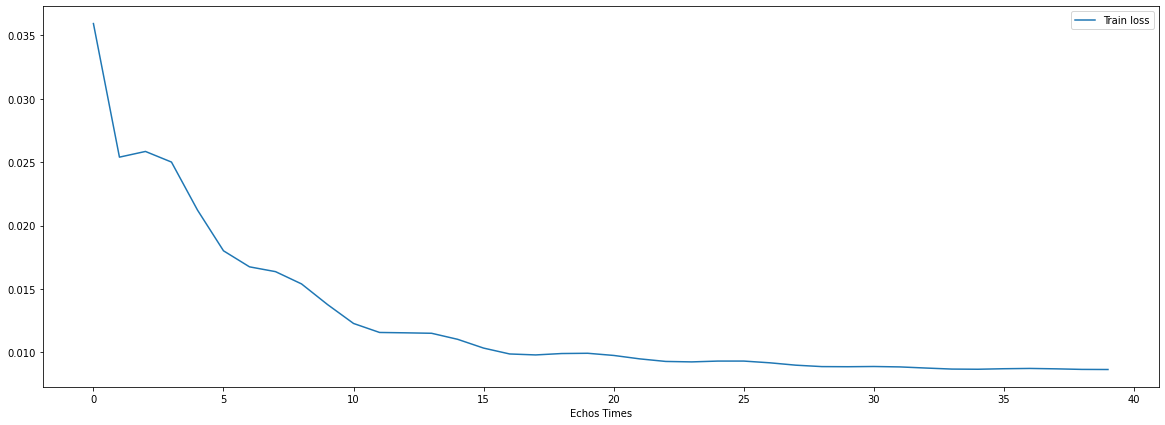

In [28]:
myplot.model_loss({"Train loss":train_hist_geo}, path=plot_path+"geo_loss.png")

## Semigeo Features

In [15]:
model_semigeo = MLP_Regression(
  input_size=50,
  hidden_size=1000
)

In [16]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03707854077219963 test loss: 0.02906520664691925
Epoch 10 train loss: 0.012672620825469494 test loss: 0.0119072450324893
Epoch 20 train loss: 0.009279022924602032 test loss: 0.009706170298159122
Epoch 30 train loss: 0.008644502609968185 test loss: 0.008861442096531391
Epoch 39 train loss: 0.008330101147294044 test loss: 0.00832721684128046
Epoch 0 train loss: 0.00871441699564457 test loss: 0.0046925051137804985
Epoch 10 train loss: 0.010379690676927567 test loss: 0.006131383590400219
Epoch 20 train loss: 0.008570164442062378 test loss: 0.004704578313976526
Epoch 30 train loss: 0.008523871190845966 test loss: 0.004597070626914501
Epoch 39 train loss: 0.008486062288284302 test loss: 0.004554044455289841
Epoch 0 train loss: 0.008304612711071968 test loss: 0.005941377952694893
Epoch 10 train loss: 0.009788133203983307 test loss: 0.0067647299729287624
Epoch 20 train loss: 0.008271212689578533 test loss: 0.0058936974965035915
Epoch 30 train loss: 0.00820625014603138 tes

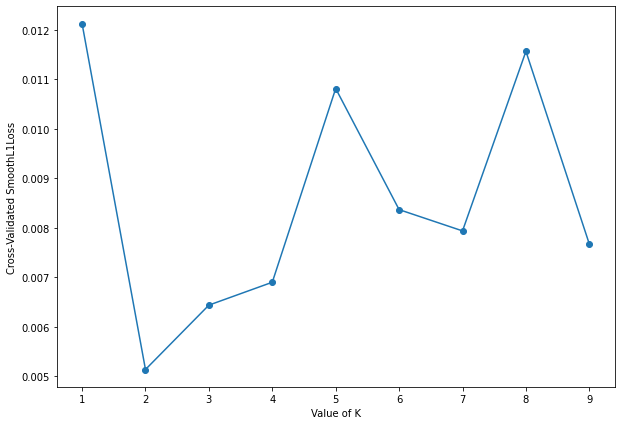

In [17]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"semigeo_k_fold.png")

### Train model

In [30]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [31]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"semigeo_model.pth")

Epoch 0 train loss: 0.03941892459988594
Epoch 10 train loss: 0.014213569462299347
Epoch 20 train loss: 0.00972019974142313
Epoch 30 train loss: 0.00864950381219387


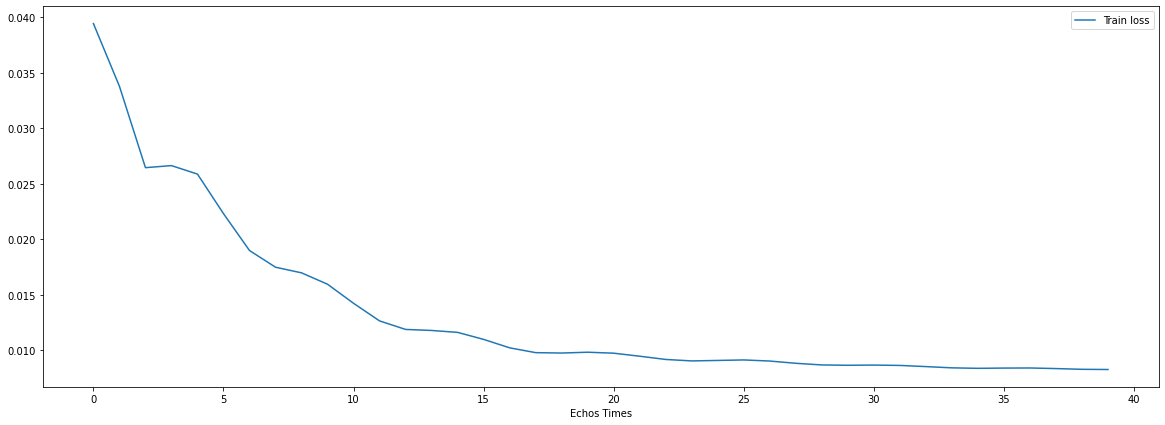

In [32]:
myplot.model_loss({"Train loss":train_hist_semigeo}, path=plot_path+"semigeo_loss.png")